# Training U-Net for Image Segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils.utils as utils
import torch
from torch.utils.data import DataLoader
import utils.load_dataset as loader
import numpy as np
from collections import Counter
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
import random
import os
from glob import glob
from torchvision.transforms import v2
from torchgeo.models import resnet18
from torchgeo.models import ResNet18_Weights
from torchsummary import summary
import utils.train as t
import model.unet as model
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from torch.autograd import Variable

/home/ubuntu/miniconda3/envs/conda_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# for GPU use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Loading Dataset

In [4]:
image_paths = sorted(glob("data/pred_patches/images/*.npy"))
mask_paths = sorted(glob("data/pred_patches/masks/*.npy"))
dataset = loader.SatelliteDataset(image_paths, mask_paths)
print(len(dataset))

1764


## Data Preprocessing

### Data Exploration
Explore Ground Truth mask 

Tree cover (0): 57868482 pixels
Shrubland (1): 6339032 pixels
Grassland (2): 19099534 pixels
Cropland (3): 5261929 pixels
Built-up (4): 1638732 pixels
Bare/sparse veg. (5): 681612 pixels
Permanent water bodies (7): 29029993 pixels
Herbaceous wetland (8): 608146 pixels


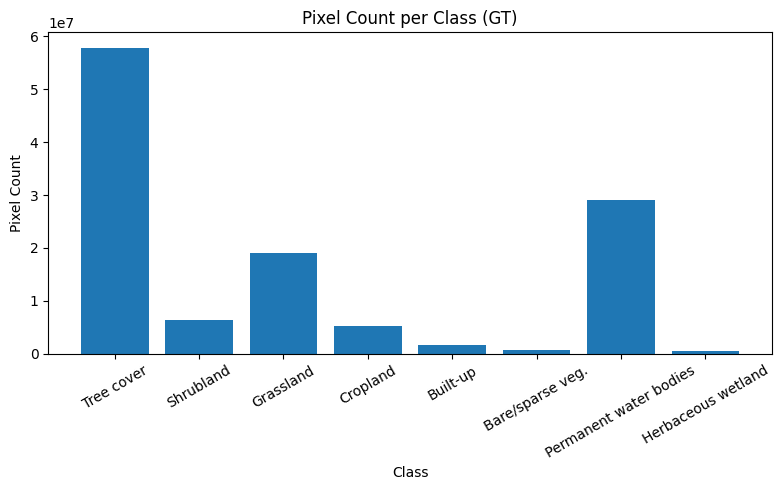

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

class_names = {
    0: "Tree cover",
    1: "Shrubland",
    2: "Grassland",
    3: "Cropland",
    4: "Built-up",
    5: "Bare/sparse veg.",
    6: "Snow and ice",
    7: "Permanent water bodies",
    8: "Herbaceous wetland",
    9: "Mangroves",
    10: "Moss/lichen",
}
label_mapping = {
    10: 0,
    20: 1,
    30: 2,
    40: 3,
    50: 4,
    60: 5,
    70: 6,
    80: 7,
    90: 8,
    95: 9,
    100: 10,
}

gt_path = "data/prediction/GBDA24_ex2_34SEH_ref_data.tif"
with rasterio.open(gt_path) as src:
    raw_mask = src.read(1)

mask = np.full(raw_mask.shape, fill_value=-1, dtype=np.int16)

for raw_val, new_val in label_mapping.items():
    mask[raw_mask == raw_val] = new_val

mask = mask[mask != -1]

unique_classes, counts = np.unique(mask, return_counts=True)
labels = [class_names[c] for c in unique_classes]

for c, count in zip(unique_classes, counts):
    print(f"{class_names[c]} ({c}): {count} pixels")

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.title("Pixel Count per Class (GT)")
plt.ylabel("Pixel Count")
plt.xlabel("Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Clean dataset from NaN values

In [ ]:
valid = []
for i in range(len(dataset)):
    _, mask = dataset[i]
    if not torch.all(mask == 255):  # at least some valid pixels
        valid.append(i)

print("Initial size of dataset:", len(dataset))
clean_dataset = Subset(dataset, valid)
print("Size of cleaned dataset:", len(clean_dataset))

Initial size of dataset: 1764
Size of cleaned dataset: 1764


### Normalization and Augmentation

In [5]:
val_transform = loader.Compose([loader.Normalize13Band()], with_mask=True)
val_dataset = loader.TorchDataset(dataset, val_transform)

In [6]:
ds_test = DataLoader(val_dataset, batch_size=32, shuffle=False)

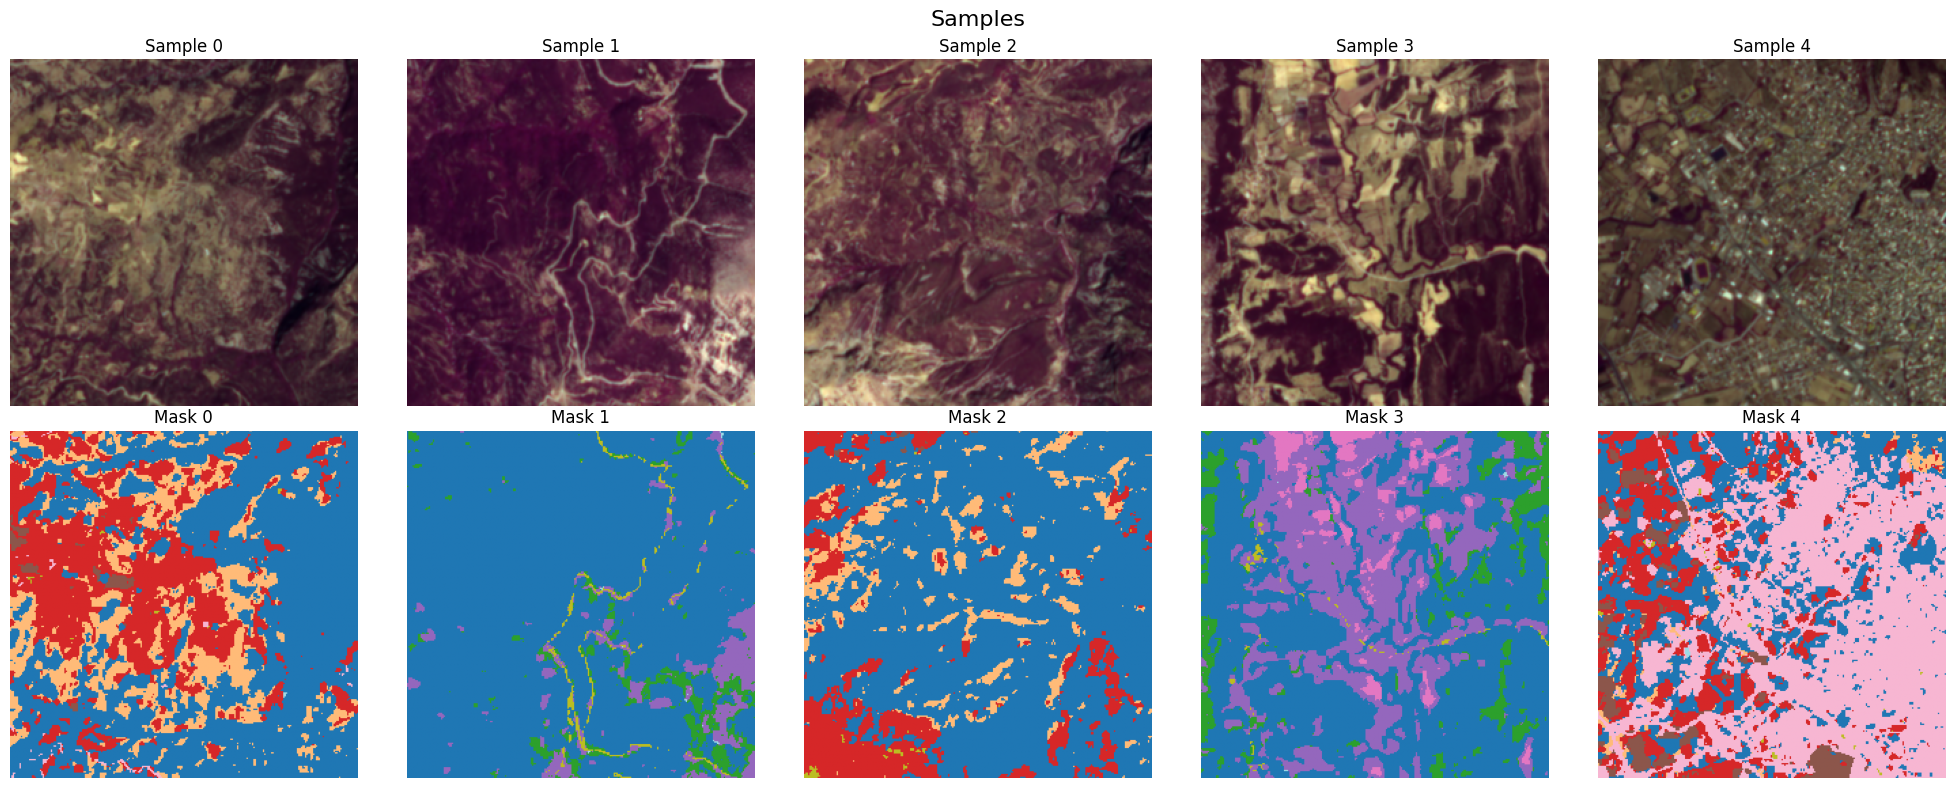

In [9]:
x_batch, y_batch = next(iter(ds_test))  # one batch from training
utils.visualize_samples(
    x_list=[x_batch[i] for i in range(5)],
    y_list=[y_batch[i] for i in range(5)],
    bands=(4, 3, 2),
)

## Model Inference

In [7]:
unet = model.UNet(num_classes=8)
unet.load_state_dict(torch.load("/home/ubuntu/bdrs_exercise_1/output/fine_tuning.pt"))
unet.to(device)

t.segmentation_report(unet, ds_test)

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0     0.8831    0.9460    0.9135  55652974
     Class 1     0.6330    0.1873    0.2891   5955831
     Class 2     0.7347    0.6935    0.7135  17770928
     Class 3     0.6137    0.7489    0.6746   5047662
     Class 4     0.5113    0.6183    0.5597   1591924
     Class 5     0.5483    0.5051    0.5258    618959
     Class 6     0.9911    0.9971    0.9941  28338257
     Class 7     0.6119    0.2860    0.3898    607466

   micro avg     0.8615    0.8617    0.8616 115584001
   macro avg     0.6909    0.6228    0.6325 115584001
weighted avg     0.8538    0.8617    0.8502 115584001

=== Dice per Class ===
0: 0.9135
1: 0.2891
2: 0.7135
3: 0.6746
4: 0.5597
5: 0.5258
6: 0.9941
7: 0.3898

=== IoU per Class ===
0: 0.8407
1: 0.1690
2: 0.5546
3: 0.5090
4: 0.3886
5: 0.3567
6: 0.9882
7: 0.2421

 === Overall Performance === 
Macro-Dice: 0.6325
Macro-IoU : 0.5061


In [ ]:
t.save_predictions_patches(
    unet,
    ds_test,
    "data/pred_patches/predicted_mask_patches",
)

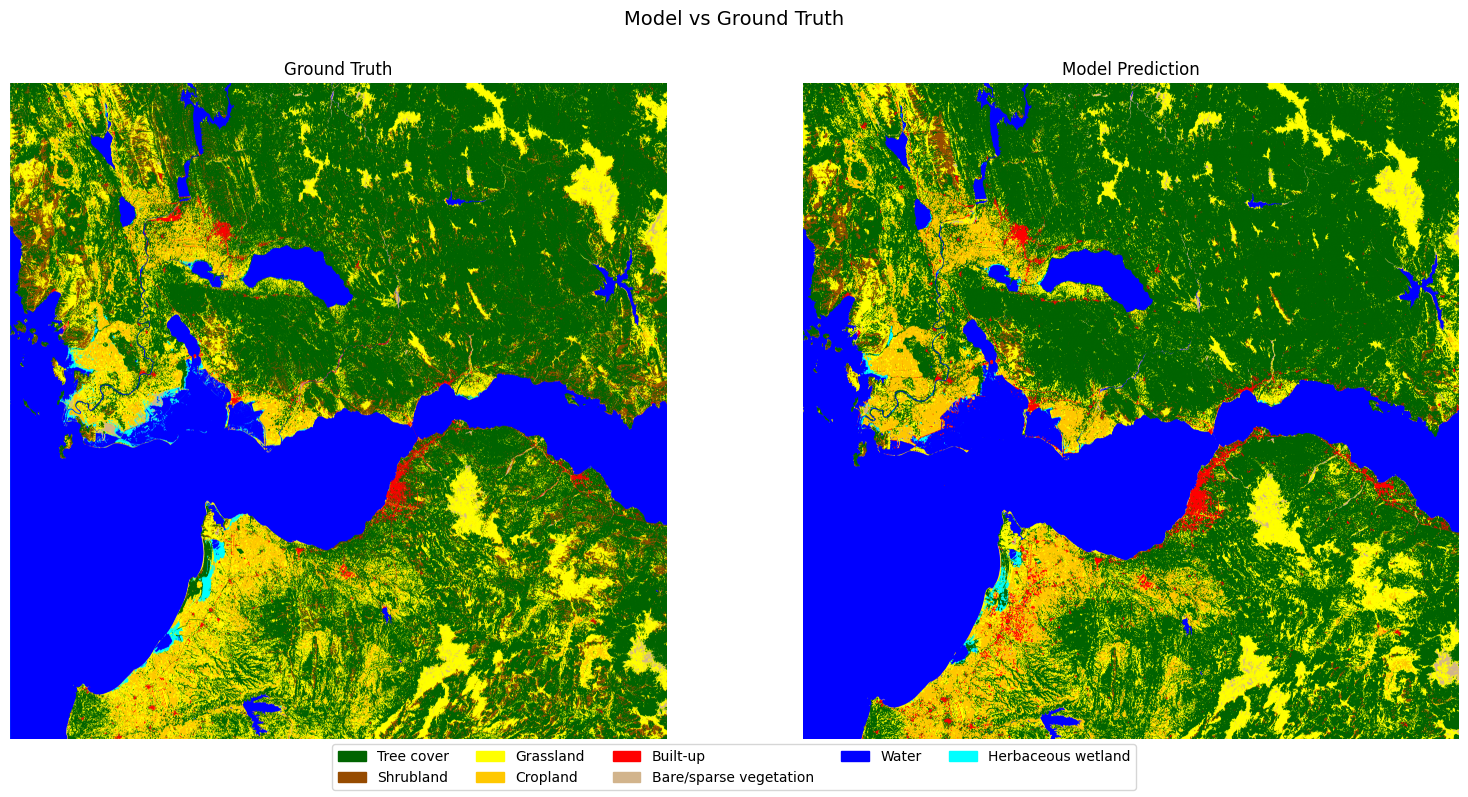

In [ ]:
class_colors = {
    0: ("Tree cover", (0, 100, 0)),
    1: ("Shrubland", (150, 75, 0)),
    2: ("Grassland", (255, 255, 0)),
    3: ("Cropland", (255, 200, 0)),
    4: ("Built-up", (255, 0, 0)),
    5: ("Bare/sparse vegetation", (210, 180, 140)),
    6: ("Water", (0, 0, 255)),
    7: ("Herbaceous wetland", (0, 255, 255)),
}


rows = 10980 // 256  # vertical tiles
cols = 10980 // 256  # horizontal tiles
prediction = utils.reconstruct_mosaic(
    "data/pred_patches/predicted_mask_patches", (rows, cols)
)
utils.plot_prediction_vs_groundtruth(
    prediction, "data/prediction/GBDA24_ex2_34SEH_ref_data.tif", class_colors
)